#### Simple code

In [2]:
! pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 2.9 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
class SyntheticTennisDataset(Dataset):
    def __init__(self, num_players=5, num_samples=1000):
        self.num_players = num_players
        self.num_samples = num_samples
        self.players = [f"Player_{i}" for i in range(num_players)]
        
        # Generate synthetic data with ALL features from the paper:
        # [ball_x, ball_y, velocity, shot_type, player_id, distance_travelled, score, ...]
        self.data = []
        for _ in range(num_samples):
            player_id = np.random.randint(0, num_players)
            ball_x = np.random.uniform(-10, 10)  # Court coordinates
            ball_y = np.random.uniform(-5, 5)
            velocity = np.random.uniform(10, 30)
            shot_type = np.random.randint(0, 8)
            distance_travelled = np.random.uniform(0, 5)  # Additional metric
            score = np.random.randint(0, 4)  # 0-0, 15-0, etc. (encoded as integers)
            
            self.data.append([
                ball_x, ball_y, velocity, shot_type, player_id,
                distance_travelled, score
            ])
        
        self.data = pd.DataFrame(
            self.data,
            columns=[
                "ball_x", "ball_y", "velocity", "shot_type", "player_id",
                "distance_travelled", "score"
            ]
        )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        # State (incoming shot): Include ALL features
        incoming_state = torch.tensor([
            sample["ball_x"], sample["ball_y"], sample["velocity"],
            sample["shot_type"], sample["distance_travelled"], sample["score"]
        ], dtype=torch.float32)
        
        # Action (outgoing shot): Simplified to [ball_x, ball_y, velocity]
        outgoing_action = torch.tensor([
            sample["ball_x"] + np.random.normal(0, 0.5),  # Simulate variation
            sample["ball_y"] + np.random.normal(0, 0.5),
            sample["velocity"] + np.random.normal(0, 1)
        ], dtype=torch.float32)
        
        return {
            "incoming": incoming_state,
            "outgoing": outgoing_action,
            "player_id": torch.tensor(sample["player_id"], dtype=torch.long),  # Fix dtype
            "shot_type": torch.tensor(sample["shot_type"], dtype=torch.long)
        }




# Split dataset into train and test
dataset = SyntheticTennisDataset()
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [81]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.distributions import Categorical, Normal

# ----------------------------
# Synthetic Tennis Dataset Preprocessing
# ----------------------------
class SyntheticTennisDataset(Dataset):
    def __init__(self, csv_path, num_players=1):
        self.data = pd.read_csv(csv_path)
        self.num_players = num_players
        
        # Rename columns to match expected features
        self.data.rename(columns={
            "frame": "frame",
            "x": "ball_x",
            "y": "ball_y",
            "vx": "velocity_x",
            "vy": "velocity_y",
            "speed": "speed",
            "direction": "shot_type",
            "distance_since_last_hit": "distance_travelled"
        }, inplace=True)
        
        # Compute additional features if needed
        self.data["velocity"] = np.sqrt(self.data["velocity_x"]**2 + self.data["velocity_y"]**2)
        
        # Fill missing or unoccured features with random values
        if "player_id" not in self.data.columns:
            self.data["player_id"] = np.random.randint(0, num_players, len(self.data))
        if "score" not in self.data.columns:
            self.data["score"] = np.random.randint(0, 4, len(self.data))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        
        # State (incoming shot): Include all features except frame index
        incoming_state = torch.tensor([
            sample["ball_x"], sample["ball_y"], sample["velocity"],
            sample["shot_type"], sample["distance_travelled"], sample["speed"],
            sample["score"]
        ], dtype=torch.float32)
        
        # Action (outgoing shot): Simplified to [ball_x, ball_y, velocity] with some added noise
        outgoing_action = torch.tensor([
            sample["ball_x"] + np.random.normal(0, 0.5),
            sample["ball_y"] + np.random.normal(0, 0.5),
            sample["velocity"] + np.random.normal(0, 1)
        ], dtype=torch.float32)
        
        return {
            "incoming": incoming_state,
            "outgoing": outgoing_action,
            "player_id": torch.tensor(sample["player_id"], dtype=torch.long),
            "shot_type": torch.tensor(sample["shot_type"], dtype=torch.long)
        }

# Load dataset from CSV
csv_path = "/Users/akashmanna/personal/SportsAI/src/dataset_prep/tennis-tracking/ball_data.csv"
dataset = SyntheticTennisDataset(csv_path)

# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [82]:
class PlayerEmbedding(nn.Module):
    def __init__(self, num_players=5, embed_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(num_players, embed_dim)
    
    def forward(self, player_ids):
        return self.embedding(player_ids.long())

In [83]:
class HistoricalContextEncoder(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, nhead=4):
        super().__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=nhead, dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
    
    def forward(self, context):
        # context shape: [batch_size, seq_len, input_dim]
        return self.transformer(context)

In [84]:


class Generator(nn.Module):
    def __init__(self, state_dim=7, player_embed_dim=32, hidden_dim=256):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim + player_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # Predicts [ball_x, ball_y, velocity]
        )
    
    def forward(self, state, player_embed):
        x = torch.cat([state, player_embed], dim=-1)
        return self.fc(x)

In [85]:


class Discriminator(nn.Module):
    def __init__(self, state_dim=7, action_dim=3, player_embed_dim=32, hidden_dim=256):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim + action_dim + player_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # For stability
        )
    
    def forward(self, state, action, player_embed):
        x = torch.cat([state, action, player_embed], dim=-1)
        return self.fc(x)

In [88]:
def train_gail(generator, discriminator, player_embedding, train_loader, epochs=100, lr=1e-4):
    opt_g = optim.Adam(generator.parameters(), lr=lr)
    opt_d = optim.Adam(discriminator.parameters(), lr=lr)
    criterion = nn.BCELoss()  # Binary cross-entropy for GAN
    
    for epoch in range(epochs):
        for batch in train_loader:
            real_state = batch["incoming"]
            real_action = batch["outgoing"]
            player_ids = batch["player_id"]
            
            # Player embeddings
            player_embeds = player_embedding(player_ids)
            
            # --- Train Generator ---
            fake_action = generator(real_state, player_embeds)
            fake_score = discriminator(real_state, fake_action, player_embeds)
            loss_g = criterion(fake_score, torch.ones_like(fake_score))
            
            opt_g.zero_grad()
            loss_g.backward(retain_graph = True)
            opt_g.step()
            
            # --- Train Discriminator ---
            # Real data
            real_score = discriminator(real_state, real_action, player_embeds)
            loss_real = criterion(real_score, torch.ones_like(real_score))
            
            # Fake data (use current generator without tracking gradients)
            # with torch.no_grad():
            fake_action = generator(real_state, player_embeds)
            fake_score = discriminator(real_state, fake_action, player_embeds)
            loss_fake = criterion(fake_score, torch.zeros_like(fake_score))
            
            loss_d = (loss_real + loss_fake) / 2
            opt_d.zero_grad()
            loss_d.backward(retain_graph = True)
            opt_d.step()
        
        print(f"Epoch {epoch+1}/{epochs} | Loss D: {loss_d.item():.4f} | Loss G: {loss_g.item():.4f}")

        

In [89]:
if __name__ == "__main__":
    # Initialize models
    player_embedding = PlayerEmbedding(num_players=5)
    generator = Generator()
    discriminator = Discriminator()
    
    # Train
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)
    train_gail(generator, discriminator, player_embedding, train_loader, epochs=100, lr=0.001)

Epoch 1/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 2/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 3/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 4/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 5/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 6/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 7/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 8/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 9/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 10/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 11/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 12/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 13/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 14/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 15/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 16/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 17/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 18/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 19/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 20/100 | Loss D: 50.0000 | Loss G: 0.0000
Epoch 21/100 | Loss D: 50.0000 | Loss G: 0.0000
E

In [90]:
def evaluate_model(generator, test_loader, player_embedding):
    bounce_errors = []
    speed_errors = []
    
    with torch.no_grad():
        for batch in test_loader:
            real_state = batch["incoming"]
            real_action = batch["outgoing"]
            player_ids = batch["player_id"]
            player_embeds = player_embedding(player_ids)
            
            pred_action = generator(real_state, player_embeds)
            
            # Cartesian error for bounce location (ball_x, ball_y)
            bounce_error = torch.sqrt((pred_action[:, 0] - real_action[:, 0])**2 +
                                      (pred_action[:, 1] - real_action[:, 1])**2)
            bounce_errors.extend(bounce_error.numpy())
            
            # Speed RMSE
            speed_error = (pred_action[:, 2] - real_action[:, 2])**2
            speed_errors.extend(speed_error.numpy())
    
    avg_bounce_error = np.mean(bounce_errors)
    speed_rmse = np.sqrt(np.mean(speed_errors))
    return avg_bounce_error, speed_rmse

VIS


In [91]:
def plot_tsne(embeddings, players):
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    for i, player in enumerate(players):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], label=player)
    plt.legend()
    plt.title("t-SNE of Player Embeddings")
    plt.show()

In [92]:
def plot_bounce_density(real_actions, pred_actions):
    plt.figure(figsize=(10, 6))
    plt.scatter(real_actions[:, 0], real_actions[:, 1], alpha=0.5, label="Real")
    plt.scatter(pred_actions[:, 0], pred_actions[:, 1], alpha=0.5, label="Predicted")
    plt.xlabel("Ball X")
    plt.ylabel("Ball Y")
    plt.title("Bounce Location Distribution")
    plt.legend()
    plt.show()

Epoch 1/100 | Loss D: 10.4875 | Loss G: 51.7708
Epoch 2/100 | Loss D: 0.0000 | Loss G: 56.9378
Epoch 3/100 | Loss D: 0.0000 | Loss G: 58.6116
Epoch 4/100 | Loss D: 0.0000 | Loss G: 58.5144
Epoch 5/100 | Loss D: 0.0000 | Loss G: 62.0437
Epoch 6/100 | Loss D: 0.0000 | Loss G: 71.9090
Epoch 7/100 | Loss D: 0.0000 | Loss G: 70.2840
Epoch 8/100 | Loss D: 0.0000 | Loss G: 71.5024
Epoch 9/100 | Loss D: 0.0000 | Loss G: 65.0956
Epoch 10/100 | Loss D: 0.0000 | Loss G: 60.6396
Epoch 11/100 | Loss D: 0.0000 | Loss G: 66.8130
Epoch 12/100 | Loss D: 0.0000 | Loss G: 70.7872
Epoch 13/100 | Loss D: 0.0000 | Loss G: 74.0300
Epoch 14/100 | Loss D: 0.0000 | Loss G: 65.9647
Epoch 15/100 | Loss D: 0.0000 | Loss G: 73.4733
Epoch 16/100 | Loss D: 0.0000 | Loss G: 66.1473
Epoch 17/100 | Loss D: 0.0000 | Loss G: 73.9287
Epoch 18/100 | Loss D: 0.0000 | Loss G: 69.8803
Epoch 19/100 | Loss D: 0.0000 | Loss G: 73.5704
Epoch 20/100 | Loss D: 0.0000 | Loss G: 74.1562
Epoch 21/100 | Loss D: 0.0000 | Loss G: 77.6438


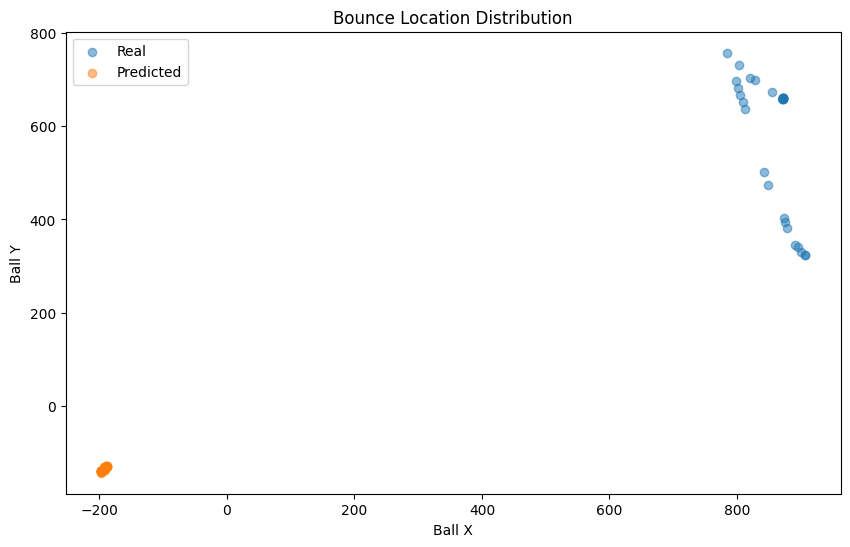

In [93]:
if __name__ == "__main__":
    # Initialize models
    player_embedding = PlayerEmbedding(num_players=5)
    generator = Generator()
    discriminator = Discriminator()
    
    # Train
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)
    train_gail(generator, discriminator, player_embedding, train_loader, epochs=100, lr=0.001)
    
    # Evaluate
    avg_bounce_error, speed_rmse = evaluate_model(generator, test_loader, player_embedding)
    print(f"Average Bounce Error: {avg_bounce_error:.2f} m | Speed RMSE: {speed_rmse:.2f} m/s")
    
    # Visualize embeddings
    # player_embeds = player_embedding.embedding.weight.detach().numpy()
    # plot_tsne(player_embeds, dataset.players)
    
    # Visualize bounce locations
    sample_batch = next(iter(test_loader))
    pred_actions = generator(sample_batch["incoming"], player_embedding(sample_batch["player_id"])).detach().numpy()
    real_actions = sample_batch["outgoing"].numpy()
    plot_bounce_density(real_actions, pred_actions)

In [105]:
 # Visualize embeddings
player_embeds = player_embedding.embedding.weight.detach().numpy()
print(player_embeds.shape)
plot_tsne(player_embeds, dataset.players)

(5, 32)


ValueError: perplexity must be less than n_samples

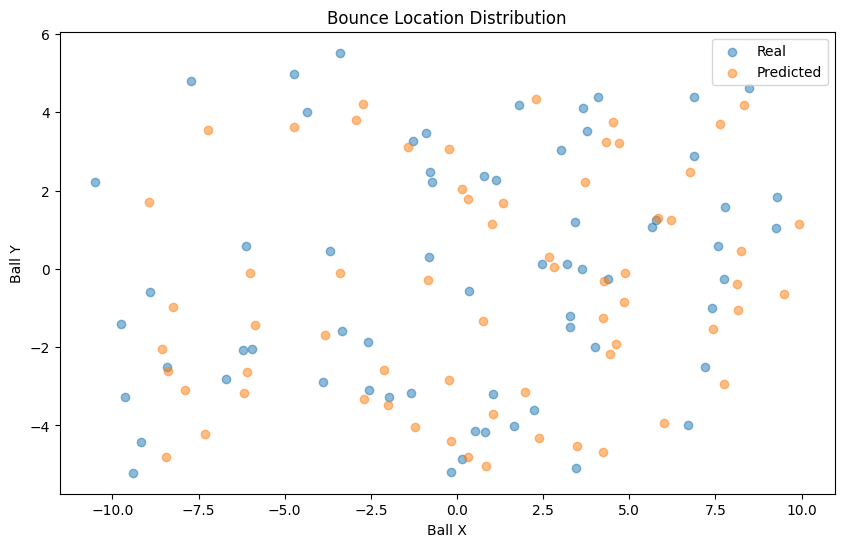

In [106]:
sample_batch = next(iter(test_loader))
pred_actions = generator(sample_batch["incoming"], player_embedding(sample_batch["player_id"])).detach().numpy()
real_actions = sample_batch["outgoing"].numpy()
plot_bounce_density(real_actions, pred_actions)

----

#### Generative adversarial Imitation Learning

In [3]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.distributions import Categorical, Normal

# ----------------------------
# Synthetic Tennis Dataset
# ----------------------------
class SyntheticTennisDataset(Dataset):
    def __init__(self, num_players=5, num_samples=10000):
        self.num_players = num_players
        self.num_samples = num_samples
        self.players = [f"Player_{i}" for i in range(num_players)]
        
        # Generate synthetic data with ALL features from the paper:
        # [ball_x, ball_y, velocity, shot_type, player_id, distance_travelled, score, ...]
        self.data = []
        for _ in range(num_samples):
            player_id = np.random.randint(0, num_players)
            ball_x = np.random.uniform(-10, 10)  # Court coordinates
            ball_y = np.random.uniform(-5, 5)
            velocity = np.random.uniform(10, 30)
            shot_type = np.random.randint(0, 8)
            distance_travelled = np.random.uniform(0, 5)  # Additional metric
            score = np.random.randint(0, 4)  # 0-0, 15-0, etc. (encoded as integers)
            
            self.data.append([
                ball_x, ball_y, velocity, shot_type, player_id,
                distance_travelled, score
            ])
        
        self.data = pd.DataFrame(
            self.data,
            columns=[
                "ball_x", "ball_y", "velocity", "shot_type", "player_id",
                "distance_travelled", "score"
            ]
        )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        # State (incoming shot): Include ALL features except player_id and shot_type if you wish,
        # here we include ball_x, ball_y, velocity, shot_type, distance_travelled, score
        incoming_state = torch.tensor([
            sample["ball_x"], sample["ball_y"], sample["velocity"],
            sample["shot_type"], sample["distance_travelled"], sample["score"]
        ], dtype=torch.float32)
        
        # Action (outgoing shot): Simplified to [ball_x, ball_y, velocity] with some added noise
        outgoing_action = torch.tensor([
            sample["ball_x"] + np.random.normal(0, 0.5),
            sample["ball_y"] + np.random.normal(0, 0.5),
            sample["velocity"] + np.random.normal(0, 1)
        ], dtype=torch.float32)
        
        return {
            "incoming": incoming_state,
            "outgoing": outgoing_action,
            "player_id": torch.tensor(sample["player_id"], dtype=torch.long),
            "shot_type": torch.tensor(sample["shot_type"], dtype=torch.long)
        }

# Split dataset into train and test
dataset = SyntheticTennisDataset()
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [5]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.distributions import Categorical, Normal

# ----------------------------
# Synthetic Tennis Dataset Preprocessing
# ----------------------------
class SyntheticTennisDataset(Dataset):
    def __init__(self, csv_path, num_players=1):
        self.data = pd.read_csv(csv_path)
        self.num_players = num_players
        
        # Rename columns to match expected features
        self.data.rename(columns={
            "frame": "frame",
            "x": "ball_x",
            "y": "ball_y",
            "vx": "velocity_x",
            "vy": "velocity_y",
            "speed": "speed",
            "direction": "shot_type",
            "distance_since_last_hit": "distance_travelled"
        }, inplace=True)
        
        # Compute additional features if needed
        self.data["velocity"] = np.sqrt(self.data["velocity_x"]**2 + self.data["velocity_y"]**2)
        
        # Fill missing or unoccured features with random values
        if "player_id" not in self.data.columns:
            self.data["player_id"] = 1 #np.random.randint(0, num_players, len(self.data))
        if "score" not in self.data.columns:
            self.data["score"] = 1#np.random.randint(0, 4, len(self.data))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        
        # State (incoming shot): Include all features except frame index
        incoming_state = torch.tensor([
            sample["ball_x"], sample["ball_y"], sample["velocity"],
            sample["shot_type"], sample["distance_travelled"], sample["speed"],
            sample["score"]
        ], dtype=torch.float32)
        
        # Action (outgoing shot): Simplified to [ball_x, ball_y, velocity] with some added noise
        outgoing_action = torch.tensor([
            sample["ball_x"] + np.random.normal(0, 0.5),
            sample["ball_y"] + np.random.normal(0, 0.5),
            sample["velocity"] + np.random.normal(0, 1)
        ], dtype=torch.float32)
        
        return {
            "incoming": incoming_state,
            "outgoing": outgoing_action,
            "player_id": torch.tensor(sample["player_id"], dtype=torch.long),
            "shot_type": torch.tensor(sample["shot_type"], dtype=torch.long)
        }

# Load dataset from CSV
csv_path = "/home/akash/ws/personal/sportsAI/src/dataset_prep/tennis-tracking/ball_data.csv"
dataset = SyntheticTennisDataset(csv_path)

# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [6]:
train_dataset[0]

/tmp/ipykernel_1282745/3428038140.py:62: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "player_id": torch.tensor(sample["player_id"], dtype=torch.long),
/tmp/ipykernel_1282745/3428038140.py:63: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "shot_type": torch.tensor(sample["shot_type"], dtype=torch.long)


{'incoming': tensor([931.3580, 403.1729,   8.3768,   1.0000,  45.0295,   8.3768,   1.0000]),
 'outgoing': tensor([931.6600, 403.6971,   8.3853]),
 'player_id': tensor(1),
 'shot_type': tensor(1)}

In [7]:
def get_expert_trajectories(dataset, num_samples):
    trajectories = []
    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        state = sample["incoming"].numpy()
        action = sample["outgoing"].numpy()
        trajectories.append([(state, action)])
    return trajectories

expert_trajectories = get_expert_trajectories(train_dataset, num_samples=train_size)

/tmp/ipykernel_1282745/3428038140.py:62: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "player_id": torch.tensor(sample["player_id"], dtype=torch.long),
/tmp/ipykernel_1282745/3428038140.py:63: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "shot_type": torch.tensor(sample["shot_type"], dtype=torch.long)


In [11]:
# ----------------------------
# Create Expert Trajectories
# ----------------------------
# We treat each sample as a one-step trajectory: (state, action)
def get_expert_trajectories(dataset, num_samples):
    trajectories = []
    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        state = sample["incoming"].numpy()
        action = sample["outgoing"].numpy()
        trajectories.append([(state, action)])
    return trajectories

expert_trajectories = get_expert_trajectories(train_dataset, num_samples=train_size)

# ----------------------------
# Dummy Environment Wrapper
# ----------------------------
# This dummy environment uses the tennis dataset to supply states.
# It does not simulate full dynamics but allows the policy to roll out "episodes."
class SyntheticTennisEnv:
    def __init__(self, dataset, episode_length=10):
        self.dataset = dataset
        self.episode_length = episode_length
        self.steps = 0
    
    def reset(self):
        self.steps = 0
        idx = np.random.randint(0, len(self.dataset))
        sample = self.dataset[idx]
        return sample["incoming"].numpy()
    
    def step(self, action):
        self.steps += 1
        idx = np.random.randint(0, len(self.dataset))
        sample = self.dataset[idx]
        next_state = sample["incoming"].numpy()
        reward = 0  # Dummy reward; the true cost is provided via the discriminator.
        done = self.steps >= self.episode_length
        return next_state, reward, done, {}

# ----------------------------
# Define Networks
# ----------------------------
# Discriminator: input is state concatenated with action.
class Discriminator(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim + action_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.model(x)

# Policy: outputs a mean for a Gaussian distribution (with fixed learned log_std)
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
        # Fixed parameter for log standard deviation
        self.log_std = nn.Parameter(torch.zeros(action_dim))
    
    def forward(self, state):
        mean = self.fc(state)
        std = torch.exp(self.log_std)
        return mean, std
    
    def act(self, state):
        mean, std = self.forward(state)
        dist = Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action, log_prob

# ----------------------------
# Trajectory Sampling
# ----------------------------
def sample_trajectories(policy, env, num_episodes=10):
    trajectories = []
    for _ in range(num_episodes):
        state = env.reset()
        episode = []
        done = False
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action, log_prob = policy.act(state_tensor)
            action_np = action.detach().squeeze(0).numpy()
            next_state, reward, done, _ = env.step(action_np)
            episode.append((state, action_np))
            state = next_state
        trajectories.append(episode)
    return trajectories

# ----------------------------
# Discriminator Training
# ----------------------------
def train_discriminator(discriminator, expert_trajectories, policy_trajectories, optimizer):
    loss_fn = nn.BCELoss()
    
    def flatten(trajs):
        states, actions = [], []
        for traj in trajs:
            for (s, a) in traj:
                states.append(s)
                actions.append(a)
        return states, actions

    expert_states, expert_actions = flatten(expert_trajectories)
    policy_states, policy_actions = flatten(policy_trajectories)
    
    expert_states = torch.tensor(np.array(expert_states), dtype=torch.float32)
    expert_actions = torch.tensor(np.array(expert_actions), dtype=torch.float32)
    policy_states = torch.tensor(np.array(policy_states), dtype=torch.float32)
    policy_actions = torch.tensor(np.array(policy_actions), dtype=torch.float32)
    
    expert_labels = torch.ones((expert_states.shape[0], 1))
    policy_labels = torch.zeros((policy_states.shape[0], 1))
    
    optimizer.zero_grad()
    expert_preds = discriminator(expert_states, expert_actions)
    policy_preds = discriminator(policy_states, policy_actions)
    loss = loss_fn(expert_preds, expert_labels) + loss_fn(policy_preds, policy_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

# ----------------------------
# TRPO Helper Functions
# ----------------------------
def flat_params(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])

def set_flat_params(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(flat_params[prev_ind:prev_ind+flat_size].view(param.size()))
        prev_ind += flat_size

def conjugate_gradient(Av_func, b, cg_iters=10, residual_tol=1e-10):
    x = torch.zeros_like(b)
    r = b.clone()
    p = r.clone()
    rdotr = torch.dot(r, r)
    
    for i in range(cg_iters):
        Avp = Av_func(p)
        alpha = rdotr / (torch.dot(p, Avp) + 1e-8)
        x += alpha * p
        r -= alpha * Avp
        new_rdotr = torch.dot(r, r)
        if new_rdotr < residual_tol:
            break
        beta = new_rdotr / (rdotr + 1e-8)
        p = r + beta * p
        rdotr = new_rdotr
    return x

def fisher_vector_product(policy, states, vector, damping=1e-2):
    mean, std = policy(states)
    dist = Normal(mean, std)
    
    # Compute KL divergence between the old and new policies (using current parameters as both).\n    
    # # (For simplicity, we compute a local quadratic approximation.)\n    
    # with torch.no_grad():       
    old_mean, old_std = mean.detach(), std.detach()
    kl = torch.distributions.kl_divergence(Normal(old_mean, old_std), Normal(mean, std)).sum(dim=1).mean()   
    grads = torch.autograd.grad(kl, policy.parameters(), create_graph=True)
    flat_grad_kl = torch.cat([grad.contiguous().view(-1) for grad in grads])
    grad_vector_product = (flat_grad_kl * vector).sum()
    grads2 = torch.autograd.grad(grad_vector_product, policy.parameters())
    flat_grad2_kl = torch.cat([grad.contiguous().view(-1) for grad in grads2])
    return flat_grad2_kl + damping * vector

# ----------------------------
# TRPO Policy Update
# ----------------------------
def update_policy_trpo(policy, trajectories, discriminator, max_kl=1e-2, damping=1e-2, cg_iters=10, ls_max_steps=10, ls_backtrack_ratio=0.8):
    old_policy = copy.deepcopy(policy)
    
    states_list, actions_list = [], []
    for traj in trajectories:
        for (s, a) in traj:
            states_list.append(s)
            actions_list.append(a)
    states = torch.tensor(np.array(states_list), dtype=torch.float32)
    actions = torch.tensor(np.array(actions_list), dtype=torch.float32)
    
    with torch.no_grad():
        mean, std = old_policy(states)
        dist = Normal(mean, std)
        old_log_probs = dist.log_prob(actions).sum(dim=-1)
    
    with torch.no_grad():
        disc_probs = discriminator(states, actions)
        advantages = torch.log(disc_probs + 1e-8).squeeze(1)
    
    def surrogate_loss():
        mean, std = policy(states)
        dist = Normal(mean, std)
        new_log_probs = dist.log_prob(actions).sum(dim=-1)
        ratio = torch.exp(new_log_probs - old_log_probs)
        return (ratio * advantages).mean()
    
    loss = surrogate_loss()
    policy.zero_grad()
    loss.backward()
    flat_grad = torch.cat([param.grad.view(-1) for param in policy.parameters()]).detach()
    
    def Fvp(v):
        return fisher_vector_product(policy, states, v, damping)
    
    step_direction = conjugate_gradient(Fvp, flat_grad, cg_iters)
    shs = 0.5 * (step_direction * Fvp(step_direction)).sum(0, keepdim=True)
    step_size = torch.sqrt(max_kl / (shs + 1e-8))
    full_step = step_direction * step_size
    old_params = flat_params(policy)
    
    def set_and_eval(step):
        new_params = old_params + step
        set_flat_params(policy, new_params)
        loss_new = surrogate_loss()
        with torch.no_grad():
            mean_new, std_new = policy(states)
            dist_new = Normal(mean_new, std_new)
            new_log_probs = dist_new.log_prob(actions).sum(dim=-1)
            old_mean, old_std = old_policy(states)
            old_dist = Normal(old_mean, old_std)
            old_log_probs_local = old_dist.log_prob(actions).sum(dim=-1)
            kl = (old_log_probs_local - new_log_probs).mean()
        return loss_new, kl
    
    expected_improve = (flat_grad * full_step).sum(0, keepdim=True)
    success = False
    for i in range(ls_max_steps):
        step = full_step * (ls_backtrack_ratio ** i)
        loss_new, kl = set_and_eval(step)
        actual_improve = loss_new - loss
        if actual_improve.item() > 0 and kl.item() <= max_kl:
            success = True
            print(f"TRPO step accepted at backtrack step {i}")
            break
    if not success:
        set_flat_params(policy, old_params)
        print("TRPO step rejected; no update performed.")
    
    return policy

# ----------------------------
# Overall GAIL+TRPO Training
# ----------------------------
def train_gail_trpo(env, expert_trajectories, state_dim, action_dim, num_iterations=100):
    policy = Policy(state_dim, action_dim)
    discriminator = Discriminator(state_dim, action_dim)
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)
    
    for i in range(num_iterations):
        # 1. Sample trajectories from the current policy using the dummy tennis environment.
        policy_trajectories = sample_trajectories(policy, env)
        
        # 2. Update the discriminator with expert trajectories and policy trajectories.
        disc_loss = train_discriminator(discriminator, expert_trajectories, policy_trajectories, disc_optimizer)
        
        # 3. Update the policy with TRPO using the cost function Q(s,a)=log(D(s,a))
        # print(">>>>>>", policy, policy_trajectories)
        policy = update_policy_trpo(policy, policy_trajectories, discriminator)
        
        print(f"Iteration {i}: Discriminator Loss = {disc_loss}")
    
    return policy

# ----------------------------
# Run Training
# ----------------------------
state_dim = 7   # "incoming" has 6 features: ball_x, ball_y, velocity, shot_type, distance_travelled, score
action_dim = 3  # "outgoing" has 3 features: ball_x, ball_y, velocity
env = SyntheticTennisEnv(train_dataset, episode_length=1000)
trained_policy = train_gail_trpo(env, expert_trajectories, state_dim, action_dim, num_iterations=50)


/tmp/ipykernel_1282745/3428038140.py:62: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "player_id": torch.tensor(sample["player_id"], dtype=torch.long),
/tmp/ipykernel_1282745/3428038140.py:63: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "shot_type": torch.tensor(sample["shot_type"], dtype=torch.long)


TRPO step accepted at backtrack step 0
Iteration 0: Discriminator Loss = 136.092529296875
TRPO step rejected; no update performed.
Iteration 1: Discriminator Loss = 121.91828918457031
TRPO step rejected; no update performed.
Iteration 2: Discriminator Loss = 109.80437469482422
TRPO step rejected; no update performed.
Iteration 3: Discriminator Loss = 101.21861267089844
TRPO step rejected; no update performed.
Iteration 4: Discriminator Loss = 100.00009155273438
TRPO step rejected; no update performed.
Iteration 5: Discriminator Loss = 100.0
TRPO step rejected; no update performed.
Iteration 6: Discriminator Loss = 100.0
TRPO step rejected; no update performed.
Iteration 7: Discriminator Loss = 100.0
TRPO step rejected; no update performed.
Iteration 8: Discriminator Loss = 100.0
TRPO step rejected; no update performed.
Iteration 9: Discriminator Loss = 100.0
TRPO step rejected; no update performed.
Iteration 10: Discriminator Loss = 100.0
TRPO step rejected; no update performed.
Iterat

In [12]:
import torch
import numpy as np

def evaluate_policy_on_test(trained_policy, test_dataset):
    """
    Evaluate the trained policy on the test dataset by computing:
    - Average bounce error: Euclidean distance between predicted and expert bounce locations (ball_x, ball_y).
    - Average velocity error: Absolute error in predicted velocity.
    """
    bounce_errors = []
    velocity_errors = []
    
    for sample in test_dataset:
        # Get state from test sample (incoming shot)
        state = sample["incoming"].unsqueeze(0)  # Shape: [1, state_dim]
        expert_action = sample["outgoing"]
        
        # Compute policy output (mean and std) and use the mean as the predicted action
        mean, _ = trained_policy(state)
        mean = mean.squeeze(0)
        
        # Bounce error: Euclidean distance in the ball's (x, y) coordinates
        bounce_error = torch.sqrt((mean[0] - expert_action[0])**2 + (mean[1] - expert_action[1])**2)
        bounce_errors.append(bounce_error.item())
        
        # Velocity error: Absolute difference in velocity (3rd dimension)
        velocity_error = torch.abs(mean[2] - expert_action[2])
        velocity_errors.append(velocity_error.item())
    
    avg_bounce_error = np.mean(bounce_errors)
    avg_velocity_error = np.mean(velocity_errors)
    
    print("Average Bounce Error on test dataset:", avg_bounce_error)
    print("Average Velocity Error on test dataset:", avg_velocity_error)

# Run evaluation
evaluate_policy_on_test(trained_policy, test_dataset)


Average Bounce Error on test dataset: 1051.9350406551018
Average Velocity Error on test dataset: 48.964207037375395


/tmp/ipykernel_1282745/3428038140.py:62: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "player_id": torch.tensor(sample["player_id"], dtype=torch.long),
/tmp/ipykernel_1282745/3428038140.py:63: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "shot_type": torch.tensor(sample["shot_type"], dtype=torch.long)


Average Bounce Error on test dataset: 1051.8776306371108
Average Velocity Error on test dataset: 48.93294186062283


/tmp/ipykernel_1282745/3428038140.py:62: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "player_id": torch.tensor(sample["player_id"], dtype=torch.long),
/tmp/ipykernel_1282745/3428038140.py:63: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  "shot_type": torch.tensor(sample["shot_type"], dtype=torch.long)


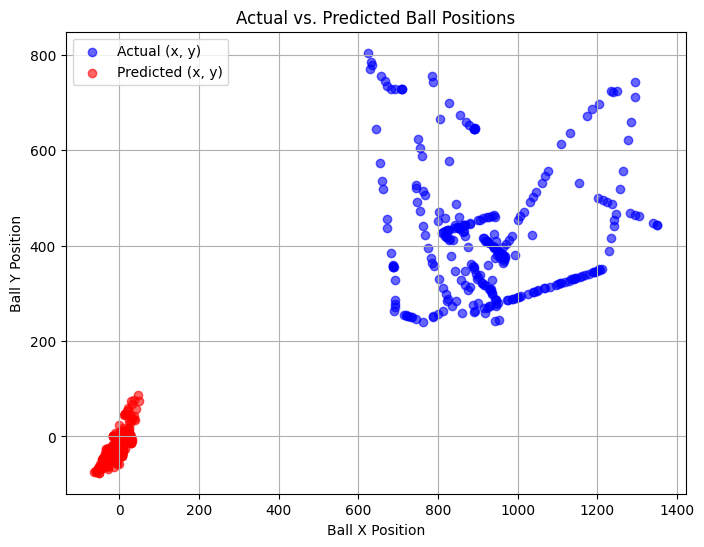

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate_policy_on_test(trained_policy, test_dataset):
    """
    Evaluate the trained policy on the test dataset and plot actual vs. predicted (x, y) positions.
    """
    bounce_errors = []
    velocity_errors = []
    actual_positions = []
    predicted_positions = []

    for sample in test_dataset:
        # Get state from test sample (incoming shot)
        state = sample["incoming"].unsqueeze(0)  # Shape: [1, state_dim]
        expert_action = sample["outgoing"]

        # Compute policy output (mean and std) and use the mean as the predicted action
        mean, _ = trained_policy(state)
        mean = mean.squeeze(0)

        # Bounce error: Euclidean distance in the ball's (x, y) coordinates
        bounce_error = torch.sqrt((mean[0] - expert_action[0])**2 + (mean[1] - expert_action[1])**2)
        bounce_errors.append(bounce_error.item())

        # Velocity error: Absolute difference in velocity (3rd dimension)
        velocity_error = torch.abs(mean[2] - expert_action[2])
        velocity_errors.append(velocity_error.item())

        # Store actual and predicted positions for visualization
        actual_positions.append((expert_action[0].item(), expert_action[1].item()))
        predicted_positions.append((mean[0].item(), mean[1].item()))

    # Compute average errors
    avg_bounce_error = np.mean(bounce_errors)
    avg_velocity_error = np.mean(velocity_errors)

    print("Average Bounce Error on test dataset:", avg_bounce_error)
    print("Average Velocity Error on test dataset:", avg_velocity_error)

    # Convert lists to numpy arrays for easy plotting
    actual_positions = np.array(actual_positions)
    predicted_positions = np.array(predicted_positions)

    # Plot actual vs. predicted positions
    plt.figure(figsize=(8, 6))
    plt.scatter( actual_positions[:, 0], actual_positions[:, 1], color='blue', label="Actual (x, y)", alpha=0.6)
    plt.scatter(predicted_positions[:, 0], predicted_positions[:, 1], color='red', label="Predicted (x, y)", alpha=0.6)
    plt.legend()
    plt.xlabel("Ball X Position")
    plt.ylabel("Ball Y Position")
    plt.title("Actual vs. Predicted Ball Positions")
    plt.grid(True)
    plt.show()

# Run evaluation
evaluate_policy_on_test(trained_policy, test_dataset)
